In [ ]:
! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download faresabbasai2022/skin-burn-dataset

 99% 108M/109M [00:01<00:00, 134MB/s] 
100% 109M/109M [00:01<00:00, 113MB/s]


In [ ]:
! unzip skin-burn-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: skin burn dataset/train/1st degree burn/img352.jpg  
  inflating: skin burn dataset/train/1st degree burn/img352_jpg.rf.230a0720bc02b7289806fd9d615b17cb.jpg  
  inflating: skin burn dataset/train/1st degree burn/img352_jpg.rf.277114adf3996014a550c848f1f38350.jpg  
  inflating: skin burn dataset/train/1st degree burn/img352_jpg.rf.2b3ac2c35f277219b993fbcde4d54359.jpg  
  inflating: skin burn dataset/train/1st degree burn/img352_jpg.rf.402cf83af7811fde1fbdc995dbae6700.jpg  
  inflating: skin burn dataset/train/1st degree burn/img352_jpg.rf.948efd87c5ee29eb8ecbede4e520df50.jpg  
  inflating: skin burn dataset/train/1st degree burn/img352_jpg.rf.a44a21afd6eb162d253950739552b6e2.jpg  
  inflating: skin burn dataset/train/1st degree burn/img354.jpg  
  inflating: skin burn dataset/train/1st degree burn/img354_jpg.rf.9d74ca95ab64589aad0029abbb739821.jpg  
  inflating: skin burn dataset/train/1st degree burn/img354_jpg.rf.a397f59a

Retriving data from kaggle

In [ ]:
train_path = "/content/skin burn dataset/train"
valid_path = "/content/skin burn dataset/valid"
test_path = "/content/skin burn dataset/test"

Importing necessary libraries

In [ ]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
#from keras.utils.vis_utils import plot_model
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import cv2
import warnings
warnings.filterwarnings('ignore')

In [ ]:
x_data = []
y_data = []

for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append(category.split("/")[-1])

data=pd.DataFrame({'image': x_data,'label': y_data})

100%|██████████| 973/973 [00:04<00:00, 227.43it/s]


In [ ]:
data.shape

(5500, 2)

Visualizing training data

In [ ]:
from collections import Counter
Counter(y_data)

Counter({'2nd degree burn': 2343,
         '3nd degree burn': 973,
         '1st degree burn': 2184})

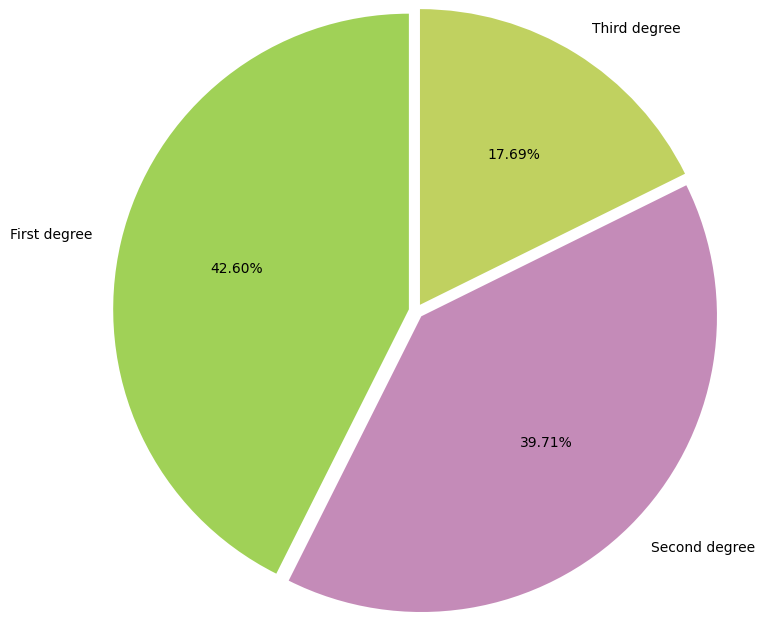

In [ ]:
colors = ['#a0d157','#c48bb8','#c0d160']
plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05,0.05],autopct='%0.2f%%',
        labels=['First degree', 'Second degree','Third degree'], colors= colors,radius=2)
plt.show()

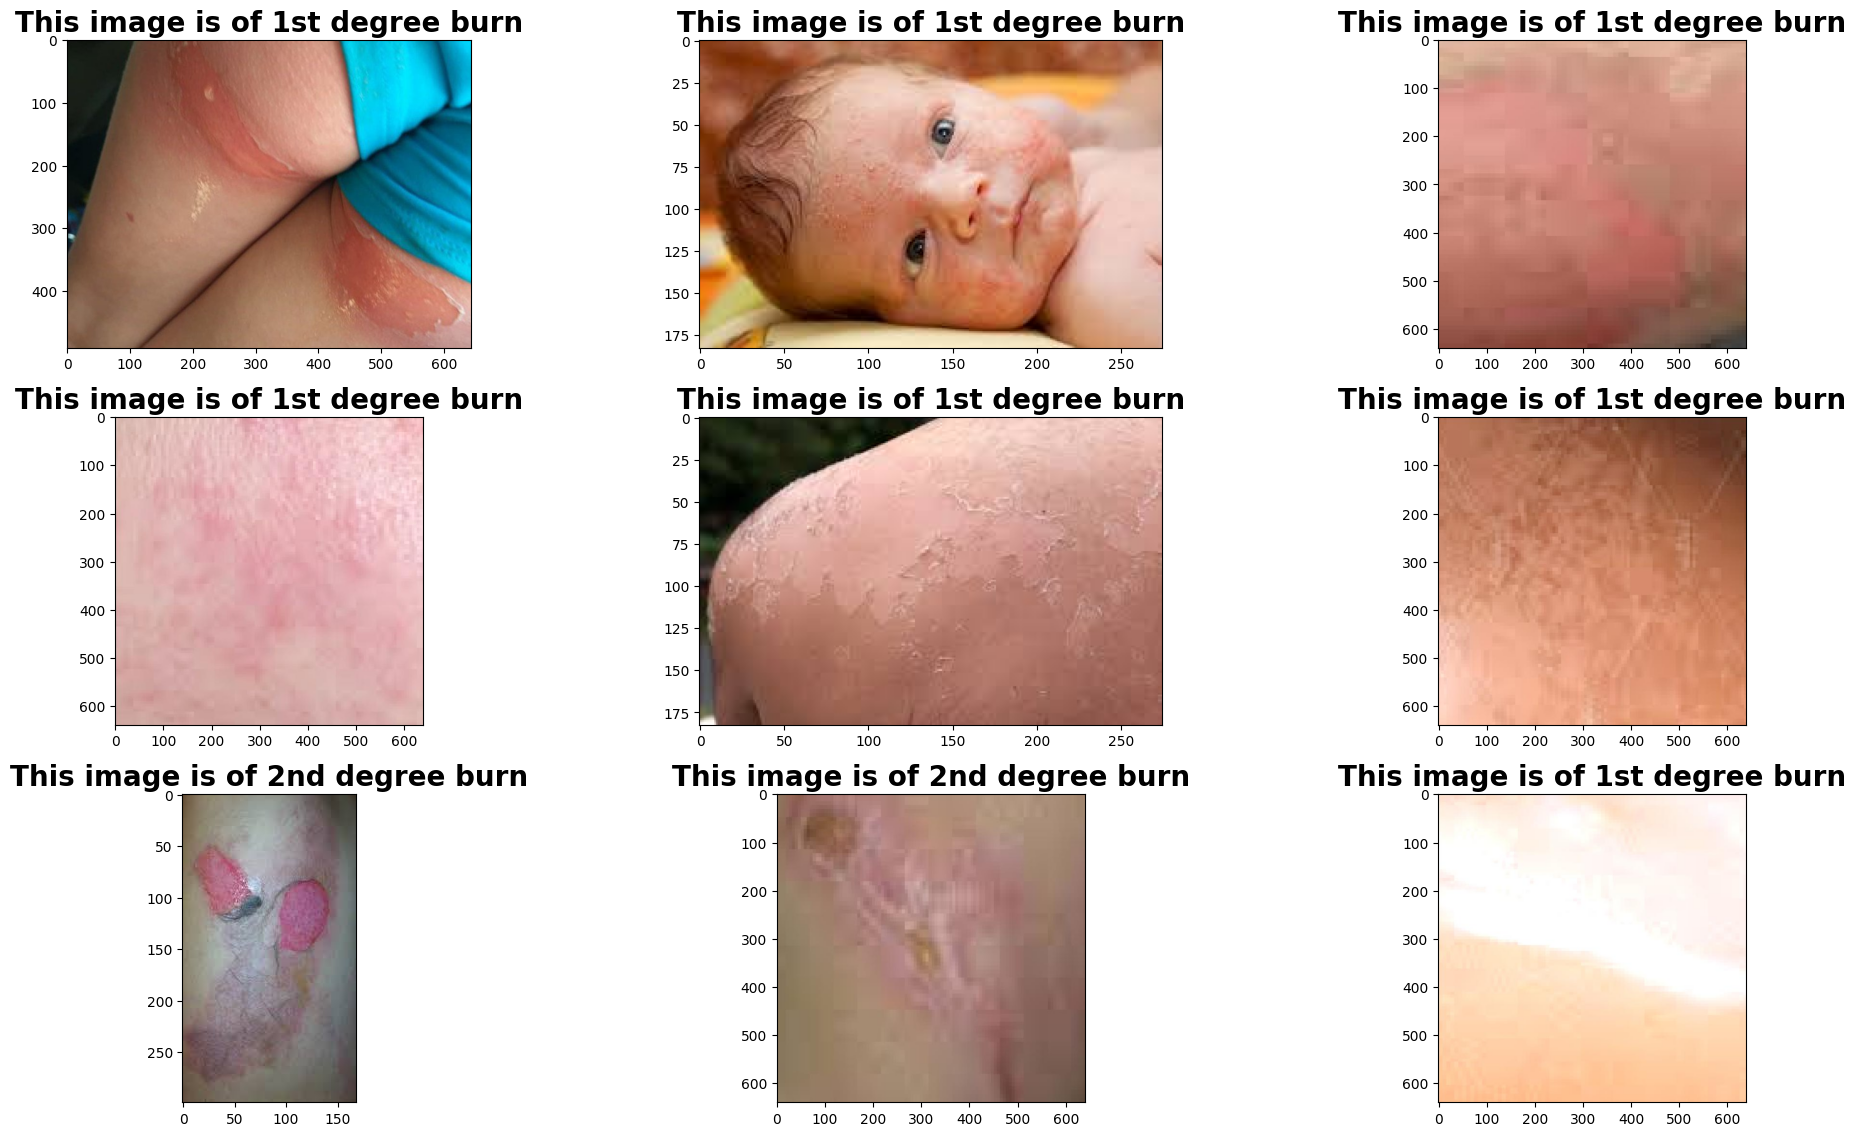

In [ ]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(5500)
    plt.title('This image is of {0}'.format(data.label[index]),fontdict={'size':20,'weight':'bold'})
    plt.imshow(data.image[index])
    plt.tight_layout()

In [ ]:
className = glob(train_path + '/*' )
numberOfClass = len(className)
print("Number Of Class: ",numberOfClass)

Number Of Class:  3


Data Augmentation and Pre-Processing

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,      # Rotate images randomly within the range (in degrees)
    horizontal_flip=True,   # Flip images horizontally
    brightness_range=(0.8, 1.2))  # Adjust brightness of images

In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,      # Rotate images randomly within the range (in degrees)
    horizontal_flip=True   # Flip images horizontally
    brightness_range=(0.8, 1.2))  # Adjust brightness of images



In [ ]:
batch_size=64
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

Found 5500 images belonging to 3 classes.
Found 5500 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD

MODEL 1 : VGG16


Building vgg16 model

In [ ]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False
model = Sequential()
model.add(vgg_model)
model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(50))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(20))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(3)) # output
model.add(Activation("softmax"))
# Compile the model
sgd = SGD(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
# Print model summary
model.summary()



9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 128)         1474688   
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 128)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 64)          73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 1, 64)          0         
 g2D)                                                      

Training vgg16 model

In [ ]:
vgg_hist = model.fit_generator(
        generator = train_generator,
        epochs=30,
        validation_data = test_generator)

Epoch 1/30
86/86 [==============================] - 50s 473ms/step - loss: 1.0657 - accuracy: 0.4687 - val_loss: 0.8645 - val_accuracy: 0.5938
Epoch 2/30
86/86 [==============================] - 34s 392ms/step - loss: 0.9124 - accuracy: 0.5475 - val_loss: 0.7956 - val_accuracy: 0.6511
Epoch 3/30
86/86 [==============================] - 37s 432ms/step - loss: 0.8622 - accuracy: 0.5976 - val_loss: 0.7335 - val_accuracy: 0.7105
Epoch 4/30
86/86 [==============================] - 36s 418ms/step - loss: 0.8120 - accuracy: 0.6302 - val_loss: 0.6792 - val_accuracy: 0.7267
Epoch 5/30
86/86 [==============================] - 35s 410ms/step - loss: 0.7761 - accuracy: 0.6562 - val_loss: 0.6385 - val_accuracy: 0.7580
Epoch 6/30
86/86 [==============================] - 37s 436ms/step - loss: 0.7350 - accuracy: 0.6802 - val_loss: 0.6751 - val_accuracy: 0.7373
Epoch 7/30
86/86 [==============================] - 37s 437ms/step - loss: 0.7102 - accuracy: 0.7056 - val_loss: 0.5515 - val_accuracy: 0.7953

Visualizing the accuracy of vgg16 model

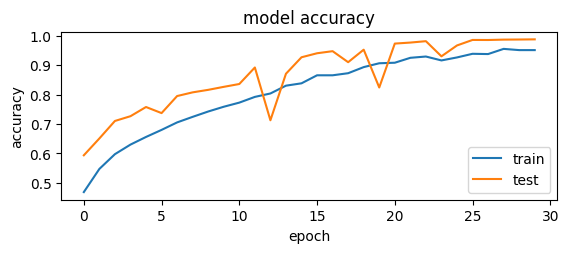

In [ ]:
import matplotlib.pyplot as plot
plot.subplot(2,1,1)
plot.plot(vgg_hist.history['accuracy'])
plot.plot(vgg_hist.history['val_accuracy'])
plot.title('model accuracy')
plot.ylabel('accuracy')
plot.xlabel('epoch')
plot.legend(['train', 'test'], loc='lower right')

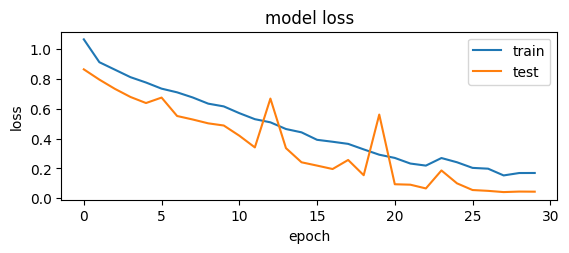

In [ ]:
plot.subplot(2,1,2)
plot.plot(vgg_hist.history['loss'])
plot.plot(vgg_hist.history['val_loss'])
plot.title('model loss')
plot.ylabel('loss')
plot.xlabel('epoch')
plot.legend(['train', 'test'], loc='upper right')

MODEL 2 : MobileNet

In [ ]:
#ignore
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
val_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical')

Building MobileNet Model

In [ ]:
from tensorflow.keras.applications import MobileNetV2
# Load MobileNetV2 pre-trained model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in MobileNetV2 so they are not trainable
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of MobileNetV2
mobile_model = Sequential([
    base_model,
    Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(20, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
sgd = SGD(learning_rate=0.01)
mobile_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Print model summary
mobile_model.summary()

Training MobileNet Model

In [ ]:
mobile_hist = res_model.fit_generator(
        generator = train_generator,
        epochs=30,
        validation_data = test_generator)

Epoch 1/30
86/86 [==============================] - 72s 674ms/step - loss: 1.1395 - accuracy: 0.5036 - val_loss: 0.9106 - val_accuracy: 0.5124
Epoch 2/30
86/86 [==============================] - 51s 595ms/step - loss: 0.8135 - accuracy: 0.5989 - val_loss: 0.7941 - val_accuracy: 0.6044
Epoch 3/30
86/86 [==============================] - 66s 768ms/step - loss: 0.7533 - accuracy: 0.6482 - val_loss: 0.9028 - val_accuracy: 0.5198
Epoch 4/30
86/86 [==============================] - 51s 592ms/step - loss: 0.7062 - accuracy: 0.6758 - val_loss: 0.6170 - val_accuracy: 0.7309
Epoch 5/30
86/86 [==============================] - 51s 594ms/step - loss: 0.6592 - accuracy: 0.6904 - val_loss: 0.6262 - val_accuracy: 0.7127
Epoch 6/30
86/86 [==============================] - 49s 576ms/step - loss: 0.6402 - accuracy: 0.7051 - val_loss: 0.5716 - val_accuracy: 0.7333
Epoch 7/30
86/86 [==============================] - 50s 585ms/step - loss: 0.5989 - accuracy: 0.7244 - val_loss: 0.5236 - val_accuracy: 0.7695

Visualizing the accuracy of MobileNet Model

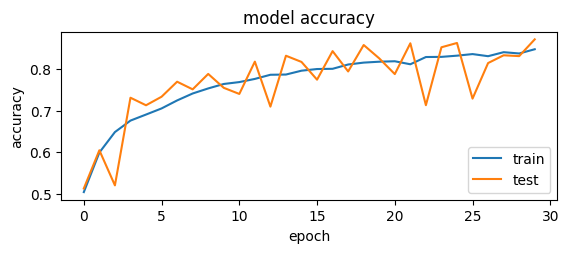

In [ ]:
import matplotlib.pyplot as plot
plot.subplot(2,1,1)
plot.plot(mobile_hist.history['accuracy'])
plot.plot(mobile_hist.history['val_accuracy'])
plot.title('model accuracy')
plot.ylabel('accuracy')
plot.xlabel('epoch')
plot.legend(['train', 'test'], loc='lower right')

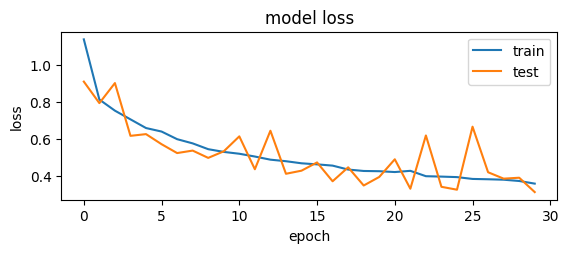

In [ ]:
plot.subplot(2,1,2)
plot.plot(mobile_hist.history['loss'])
plot.plot(mobile_hist.history['val_loss'])
plot.title('model loss')
plot.ylabel('loss')
plot.xlabel('epoch')
plot.legend(['train', 'test'], loc='upper right')

MODEL 3 : ResNet50

Building ResNet50 model

In [ ]:
from tensorflow.keras.applications import ResNet50
res_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in res_model.layers:
    layer.trainable = False
resnet_model = Sequential()
resnet_model.add(res_model)
resnet_model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
resnet_model.add(MaxPooling2D(pool_size=(2, 2)))
resnet_model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
resnet_model.add(MaxPooling2D(pool_size=(2, 2)))
resnet_model.add(Flatten())
resnet_model.add(Dense(32, activation='relu'))
resnet_model.add(Dropout(0.2))
resnet_model.add(Dense(16, activation='relu'))
resnet_model.add(Dropout(0.2))
resnet_model.add(Dense(3, activation='softmax'))
# Compile the model
sgd = SGD(learning_rate=0.01)
resnet_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
# Print model summary
resnet_model.summary()


58889256/58889256 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          294976    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 3, 3, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 1, 1, 128)         0         
 g2D)                                                            
                                                       

Training ResNet50 model

In [ ]:
hist = resnet_model.fit_generator(
        generator = train_generator,
        epochs=30,
        validation_data = test_generator)

Epoch 1/30
86/86 [==============================] - 51s 486ms/step - loss: 0.6528 - accuracy: 0.4356 - val_loss: 0.5696 - val_accuracy: 0.4651
Epoch 2/30
86/86 [==============================] - 37s 427ms/step - loss: 0.5809 - accuracy: 0.4809 - val_loss: 0.5438 - val_accuracy: 0.5495
Epoch 3/30
86/86 [==============================] - 36s 415ms/step - loss: 0.5799 - accuracy: 0.4849 - val_loss: 0.5387 - val_accuracy: 0.5500
Epoch 4/30
86/86 [==============================] - 37s 425ms/step - loss: 0.5608 - accuracy: 0.5191 - val_loss: 0.5282 - val_accuracy: 0.5747
Epoch 5/30
86/86 [==============================] - 37s 436ms/step - loss: 0.5535 - accuracy: 0.5267 - val_loss: 0.5123 - val_accuracy: 0.5898
Epoch 6/30
86/86 [==============================] - 37s 428ms/step - loss: 0.5300 - accuracy: 0.5551 - val_loss: 0.5272 - val_accuracy: 0.5376
Epoch 7/30
86/86 [==============================] - 36s 413ms/step - loss: 0.5229 - accuracy: 0.5707 - val_loss: 0.4931 - val_accuracy: 0.6005

Visualizing the accuracy of ResNet50 model

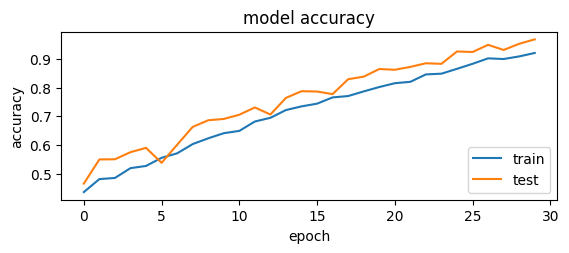

In [ ]:
import matplotlib.pyplot as plot
plot.subplot(2,1,1)
plot.plot(hist.history['accuracy'])
plot.plot(hist.history['val_accuracy'])
plot.title('model accuracy')
plot.ylabel('accuracy')
plot.xlabel('epoch')
plot.legend(['train', 'test'], loc='lower right')

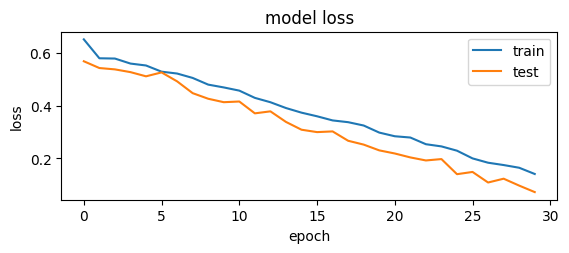

In [ ]:
plot.subplot(2,1,2)
plot.plot(hist.history['loss'])
plot.plot(hist.history['val_loss'])
plot.title('model loss')
plot.ylabel('loss')
plot.xlabel('epoch')
plot.legend(['train', 'test'], loc='upper right')